In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

Some ideas:
- statistical arbitrage
-

Resources:
- https://quantocracy.com/
- https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf


[*********************100%***********************]  1 of 1 completed


                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2022-01-03  1.137385  1.137592  1.128541  1.137346   1.137346       0
2022-01-04  1.130199  1.132300  1.127345  1.130224   1.130224       0
2022-01-05  1.128541  1.134559  1.127764  1.128363   1.128363       0
2022-01-06  1.131222  1.133067  1.128554  1.131350   1.131350       0
2022-01-07  1.129586  1.135976  1.129050  1.129688   1.129688       0


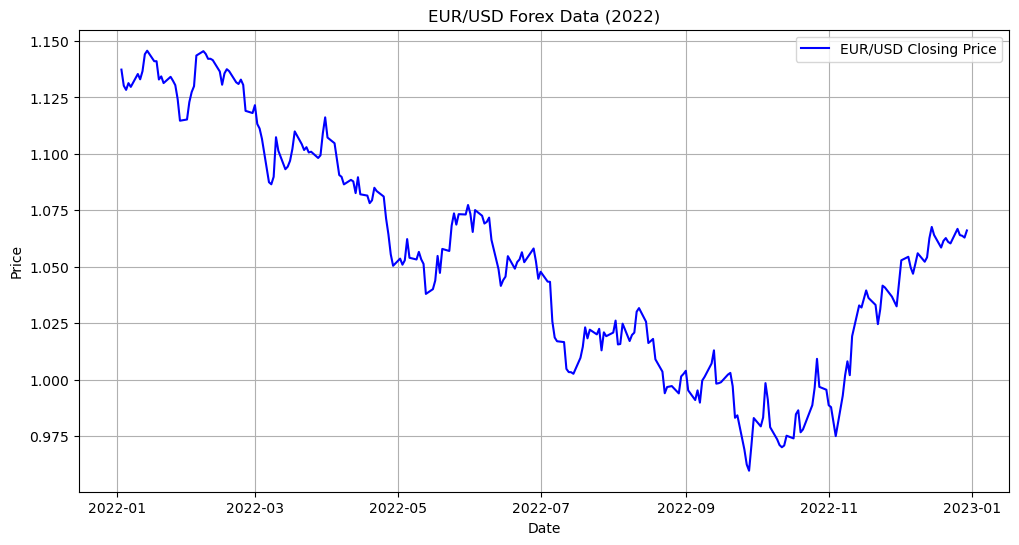

In [3]:
currency_pair = 'EURUSD=X'

# Download historical Forex data
forex_data = yf.download(currency_pair, start='2022-01-01', end='2023-01-01')

# Display the first few rows
print(forex_data.head())

# Plot the closing prices
plt.figure(figsize=(12, 6))
plt.plot(forex_data['Close'], label='EUR/USD Closing Price', color='blue')
plt.title('EUR/USD Forex Data (2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  2 of 2 completed
/Users/bx/opt/anaconda3/envs/qids/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/bx/opt/anaconda3/envs/qids/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting res

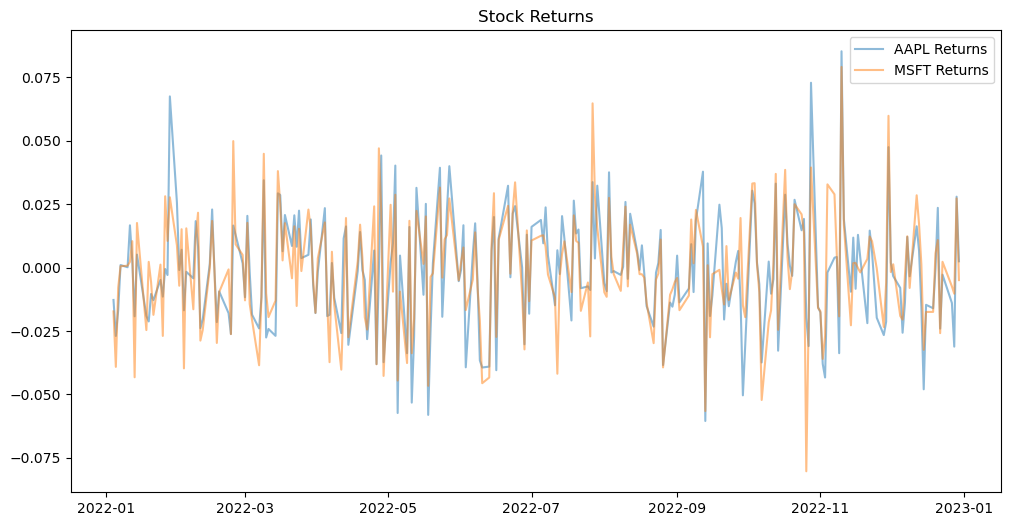

Predicted Volatility AAPL: 0.0004958071021488729
Predicted Volatility MSFT: 0.000513946311053235


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf

# Step 1: Collect Data
symbols = ['AAPL', 'MSFT']
data = yf.download(symbols, start='2022-01-01', end='2023-01-01')['Adj Close']
returns = np.log(data / data.shift(1)).dropna()

# Step 2: Fit Diagonal BEKK GARCH Model for each asset
# Fit GARCH model for each return series
aapl_model = arch_model(returns['AAPL'], vol='Garch', p=1, q=1, dist='normal')
msft_model = arch_model(returns['MSFT'], vol='Garch', p=1, q=1, dist='normal')

aapl_fit = aapl_model.fit(disp='off')
msft_fit = msft_model.fit(disp='off')

# Step 3: Forecast Volatility
aapl_forecast = aapl_fit.forecast(horizon=5)
msft_forecast = msft_fit.forecast(horizon=5)

predicted_volatility_aapl = aapl_forecast.variance.values[-1, 0]  # Get scalar value for AAPL
predicted_volatility_msft = msft_forecast.variance.values[-1, 0]  # Get scalar value for MSFT

# Step 4: Trading Strategy
# Example Strategy: Buy when predicted volatility is low
threshold_aapl = np.percentile(aapl_forecast.variance.values[-1], 25)  # Buy/Sell threshold
threshold_msft = np.percentile(msft_forecast.variance.values[-1], 25)

signals_aapl = (predicted_volatility_aapl < threshold_aapl).astype(int)  # 1 for buy, 0 for hold
signals_msft = (predicted_volatility_msft < threshold_msft).astype(int)

# Step 5: Visualization
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['AAPL'], label='AAPL Returns', alpha=0.5)
plt.plot(returns.index, returns['MSFT'], label='MSFT Returns', alpha=0.5)
plt.title('Stock Returns')
plt.legend()
plt.show()

print('Predicted Volatility AAPL:', predicted_volatility_aapl)
print('Predicted Volatility MSFT:', predicted_volatility_msft)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress
import warnings 

warnings.filterwarnings("ignore")

def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def filter_non_null_rows(df1, df2):
    # Create a mask for rows that are not null in both DataFrames
    mask = df1.notnull() & df2.notnull() 
    # Filter both DataFrames using the mask
    filtered_df1 = df1[mask.all(axis=1)]
    filtered_df2 = df2[mask.all(axis=1)]
    return filtered_df1, filtered_df2

tick_list = ['EUR=X','GBP=X', 'JPY=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X', 'MYR=X', 'ZAR=X', 'RUB=X']

if __name__ == '__main__':
    start_date = datetime.datetime(2015,1,1)
    end_date = datetime.datetime(2024,6,1)

    for i in tick_list:
        for j in tick_list:
            if i != j:
                pair1, pair2 = filter_non_null_rows(download_data(i, start_date, end_date), download_data(j, start_date, end_date))
                if np.shape(pair1) == np.shape(pair2):
                    result = linregress(pair1.values[:,0], pair2.values[:,0]) 
                    residuals = pair1 - result.slope * pair2 
                    adf = ts.adfuller(residuals)
                    if adf[1] < 0.01: #Testing for which pairs are critical in 1% significance level
                        print(i, j, adf)

SGD=X HKD=X (np.float64(-4.013372656454384), np.float64(0.0013420843138222552), 0, 2453, {'1%': np.float64(-3.433018632796697), '5%': np.float64(-2.8627189778654643), '10%': np.float64(-2.567397617255774)}, np.float64(-19477.993518011135))


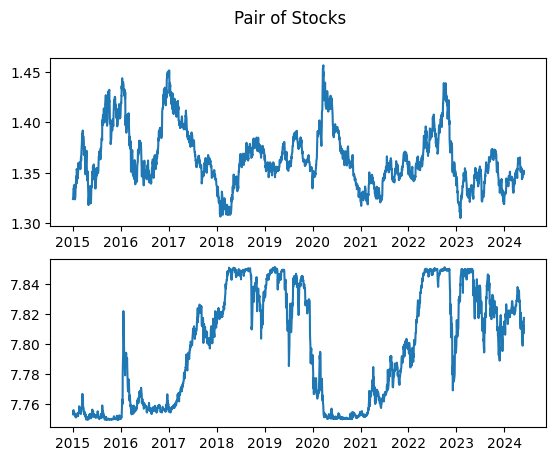

LinregressResult(slope=np.float64(-0.24941494576666143), intercept=np.float64(8.137654341553043), rvalue=np.float64(-0.19291714591889614), pvalue=np.float64(5.2859366127699415e-22), stderr=np.float64(0.025618613053744722), intercept_stderr=np.float64(0.03497607814566398))
(np.float64(-4.013372656454384), np.float64(0.0013420843138222552), 0, 2453, {'1%': np.float64(-3.433018632796697), '5%': np.float64(-2.8627189778654643), '10%': np.float64(-2.567397617255774)}, np.float64(-19477.993518011135))


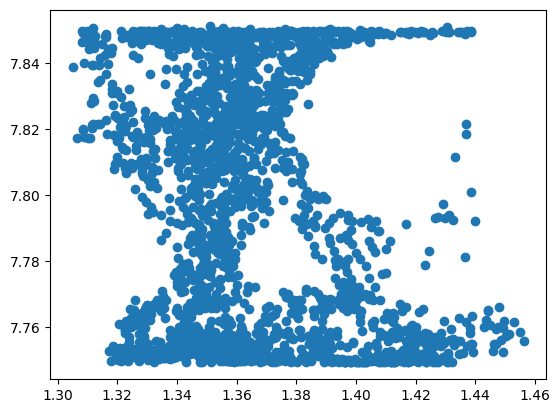

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress

def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def plot_pairs(data1, data2):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Pair of Stocks")
    ax1.plot(data1)
    ax2.plot(data2)
    plt.show()

if __name__ == '__main__':
    start_date = datetime.datetime(2015, 1,1)
    end_date = datetime.datetime(2024,6,1)

    pair1 = download_data('SGD=X', start_date, end_date)
    pair2 = download_data('HKD=X', start_date, end_date)

    plot_pairs(pair1, pair2)
    plt.scatter(pair1.values, pair2.values)

    result = linregress(pair1.values[:,0], pair2.values[:,0])
    residuals = pair1 - result.slope * pair2 
    adf = ts.adfuller(residuals) 
    print(result)
    print(adf)


    

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

if __name__ == '__main__':
    start_date = datetime.datetime(2015,1,1)
    end_date = datetime.datetime(2024,6,1)

    pair1, pair2 = filter_non_null_rows(download_data("SGD=X", start_date, end_date), download_data("HKD=X", start_date, end_date))

    combined = pd.concat([pair1, pair2], axis=1)
    combined.columns = ['SGD', 'HKD']

    johansen_test = coint_johansen(combined, det_order=0, k_ar_diff=1)

    # Print test results
    trace_stat = johansen_test.lr1  # Trace statistic
    crit_values = johansen_test.cvt  # Critical values

    print("Johansen Test Results:")
    for i in range(len(trace_stat)):
        print(f'Rank {i}: Trace Statistic = {trace_stat[i]:.4f}, Critical Value (95%) = {crit_values[i, 1]:.4f}')


[20.51173338  3.82272098]
Johansen Test Results:
Rank 0: Trace Statistic = 20.5117, Critical Value (95%) = 15.4943
Rank 1: Trace Statistic = 3.8227, Critical Value (95%) = 3.8415
